<font size = "5"> **Chapter 1: [Introduction](CH1_00-Introduction.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Open DM3 Images, Spectra, Spectrum-Images and  Image-Stacks with pyNSID 

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Introduction/CH1_04-Open_File.ipynb)
 



part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2022

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.

---
Reading a dm file and translating the data in a **[pyNSID](https://pycroscopy.github.io/pyNSID/)** style hf5py file to be compatible with  the **[pycroscopy](https://pycroscopy.github.io/pycroscopy/)** package.

Because, many other packages and programs for TEM data manipulation are based on the ``hdf5`` file-formats it is relatively easy to convert back and forward between them.



## Import packages for figures and
### Check Installed Packages

In [1]:
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError):
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2022.2.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Load the plotting and figure packages

In [1]:
%pylab --no-import-all notebook

import sys
sys.path.insert(0, '../../pyTEMlib')
import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library

import sidpy
import pyNSID
import h5py

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__='CH1_04-Reading_File'
__notebook_version__='2021_12_14'

Populating the interactive namespace from numpy and matplotlib
Symmetry functions of spglib enabled
pyTEM version:  0.2022.2.0


## Open a file 

This function opens a hfd5 file in the pyNSID style which enables you to keep track of your data analysis.

Please see the **[Installation](CH1_02-Prerequisites.ipynb#TEM-Library)** notebook for installation.

We want to consolidate files into one dataset that belongs together.  For example a spectrum image dataset consists of: 
* Survey image, 
* EELS spectra 
* Z-contrast image acquired simultaneously with the spectra.


So load the top dataset first in the above example the survey image.

Please note that the plotting routine of ``matplotlib`` was introduced in **[Matplotlib and Numpy for Micrographs](CH1_03-Data_Representation.ipynb)** notebook.

**Use the file p1-3hr.dm3 from TEM_data directory for a practice run**

In [4]:
# ------ Input ------- #
load_example = False
# -------------------- #

# Open file widget and select file which will be opened in code cell below
if not load_example:
    drive_directory = ft.get_last_path()
    file_widget = ft.FileWidget(drive_directory)

Select(description='Select file:', layout=Layout(width='70%'), options=('.',), rows=10, value='.')

Cannot overwrite file. Using:  GOLD_NP_DIFF-2.hf5


C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:350: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<IPython.core.display.Javascript object>


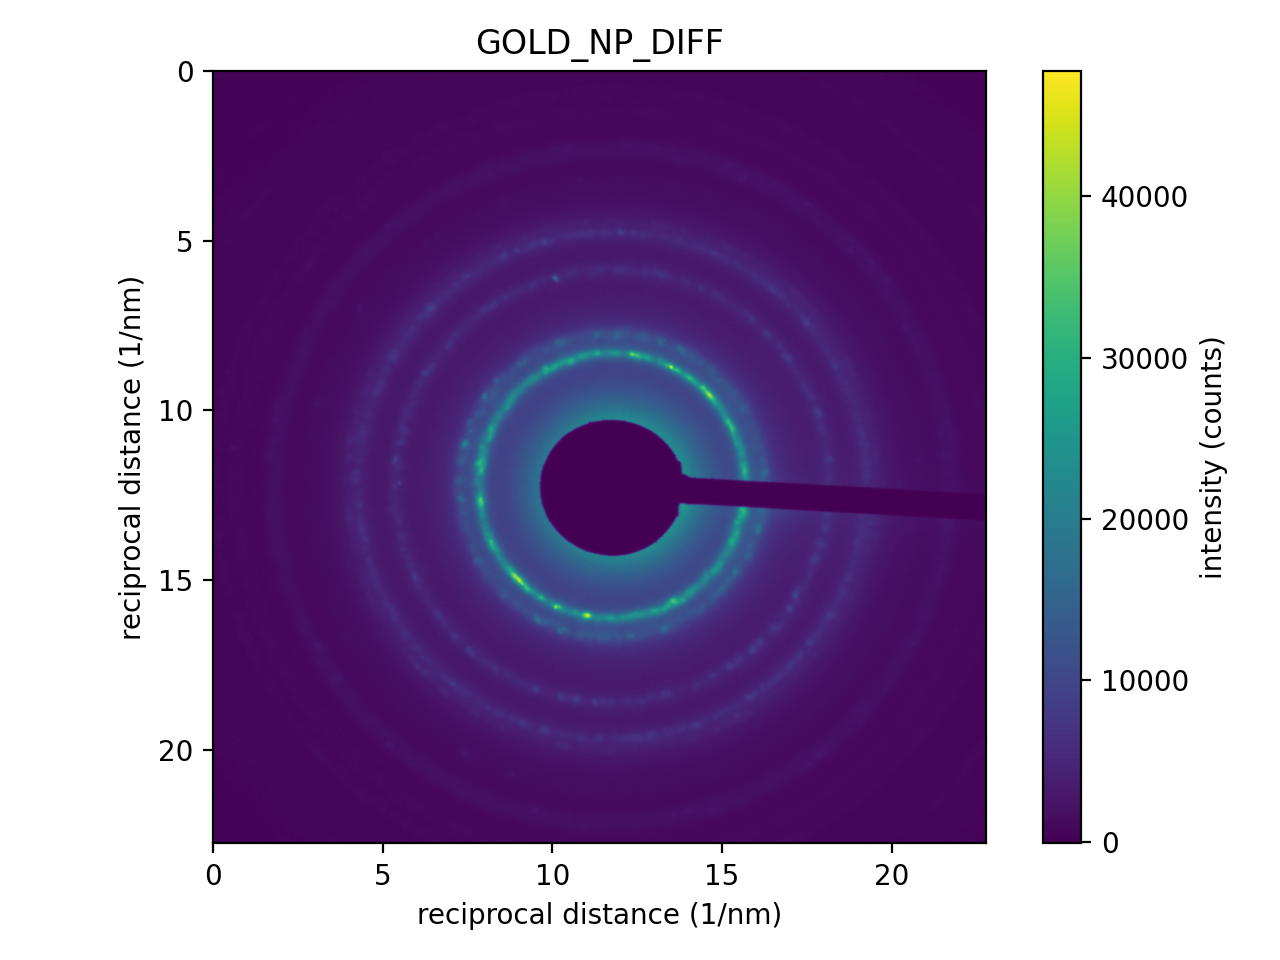

In [5]:
try:
    main_dataset.h5_dataset.file.close()
except:
    pass

if load_example:
    file_name = '../example_data/p1-3-hr3.dm3'
else:
    file_name = file_widget.file_name

main_dataset = ft.open_file(file_name)
current_channel = main_dataset.h5_dataset.parent.parent

view = main_dataset.plot()

## Data Structure

The data themselves reside in a ``sidpy dataset`` which we name ``current_dataset``.

The current_dataset has additional information stored as attributes which can be accessed through their name.

In [6]:
print(main_dataset)
main_dataset

sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(2048, 2048), dtype=int32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
u:  reciprocal distance (1/nm) of size (2048,)
v:  reciprocal distance (1/nm) of size (2048,)


sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(2048, 2048), dtype=int32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
u:  reciprocal distance (1/nm) of size (2048,)
v:  reciprocal distance (1/nm) of size (2048,)

In [7]:
print(f'size of current dataset is {main_dataset.shape}')

size of current dataset is (2048, 2048)


The current_dataset has additional information stored as attributes which can be accessed through their name.

In [8]:
print('title: ', main_dataset.title)
print('data type: ', main_dataset.data_type)
main_dataset.metadata
for key in current_channel:
    try:
        if key in current_channel[key]:
            print(current_channel[key][key]['original_metadata'].attrs.keys())
    except:
        pass

title:  GOLD_NP_DIFF
data type:  DataType.IMAGE


## File Structure
The current_channel (like a directory in a file system) contains several groups.

Below I show how to access one of those groups.

In [9]:
current_dataset = main_dataset
print(current_channel.keys())
def add_data(dataset, h5_group=None):
    """Write data to hdf5 file

    Parameters
    ----------
    dataset: sidpy.Dataset
        data to write to file
    h5_group: None, sidpy.Dataset, h5py.Group, h5py.Dataset, h5py.File
        identifier to which group the data are added (if None the dataset must have a valid h5_dataset)

    Return
    ------
    log_group: h5py.Dataset
        reference the dataset has been written to. (is also stored in h5_dataset attribute of sidpy.Dataset)
    """

    if h5_group is None:
        if isinstance(dataset.h5_dataset, h5py.Dataset):
            h5_group = dataset.h5_dataset.parent.parent.parent
    if isinstance(h5_group, h5py.Dataset):
        h5_group = h5_group.parent.parent.parent
    elif isinstance(h5_group, sidpy.Dataset):
        h5_group = h5_group.h5_dataset.parent.parent.parent
    elif isinstance(h5_group, h5py.File):
        h5_group = h5_group['Measurement_000']
        
    if not isinstance(h5_group, h5py.Group):
        raise TypeError('Need a valid identifier for a hdf5 group to store data in')

    log_group = sidpy.hdf.prov_utils.create_indexed_group(h5_group, 'Channel_')
    h5_dataset = pyNSID.hdf_io.write_nsid_dataset(dataset, log_group)
    
    if hasattr(dataset, 'meta_data'):
        if 'analysis' in dataset.meta_data:
            log_group['analysis'] = dataset.meta_data['analysis']
            
    dataset.h5_dataset = h5_dataset
    return h5_dataset

print(current_channel)
current_dataset.metadata= {'a': 'nix', 'b': 'nada'}
#new_data = pyNSID.hdf_io.write_results(current_channel.parent, dataset=current_dataset)
new_data = add_data(current_dataset, h5_group=None)

print(current_dataset.h5_dataset)
print(new_data)

<KeysViewHDF5 ['GOLD_NP_DIFF']>
<HDF5 group "/Measurement_000/Channel_000" (1 members)>
<HDF5 dataset "GOLD_NP_DIFF": shape (2048, 2048), type "<i4">
<HDF5 dataset "GOLD_NP_DIFF": shape (2048, 2048), type "<i4">


C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:350: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


An important attribute in ``current_dataset`` is the ``original_metadata`` group, where all the original metadata of your file reside in the ``attributes``. This is usually a long list for ``dm3`` files.

In [10]:
current_dataset.h5_dataset.parent['original_metadata'].keys()

<KeysViewHDF5 ['DM', 'DocumentObjectList', 'DocumentTags', 'Image Behavior', 'ImageList', 'ImageSourceList', 'MinVersionList', 'Page Behavior', 'SentinelList', 'Thumbnails']>

In [11]:
for key,value in current_dataset.h5_dataset.parent['original_metadata'].attrs.items():
    print(key, value)
print(current_dataset.h5_dataset)    

ApplicationBounds [   0    0  734 1342]
HasWindowPosition 1
InImageMode 1
LayoutType Unknown
NextDocumentObjectID 10
WindowPosition [  17  532  729 1244]
<HDF5 dataset "GOLD_NP_DIFF": shape (2048, 2048), type "<i4">


In [12]:
print(current_channel.keys())

<KeysViewHDF5 ['GOLD_NP_DIFF']>


## Adding Data

To add another dataset that belongs to this measurement we will use the **h5_add_channel** from  **file_tools** in the  pyTEMlib package.

Here is how we add a channel there.

We can also add a new measurement group (add_measurement in pyTEMlib) for similar datasets.

This is equivalent to making a new directory in a file structure on your computer.

In [13]:
import pyNSID

def add_dataset(dataset, h5_group=None):
    """Write data to hdf5 file

    Parameters
    ----------
    dataset: sidpy.Dataset
        data to write to file
    h5_group: None, sidpy.Dataset, h5py.Group, h5py.Dataset, h5py.File
        identifier to which group the data are added (if None the dataset must have a valid h5_dataset)

    Returns:
    --------
    h5_dataset: h5py.Dataset
        reference the dataset has been written to. (is also stored in h5_dataset attribute of sidpy.Dataset)
    """

    if h5_group is None:
        if isinstance(dataset.h5_dataset, h5py.Dataset):
            h5_group = dataset.h5_dataset.parent.parent.parent
    if isinstance(h5_group, h5py.Dataset):
        h5_group = h5_group.parent.parent.parent
    elif isinstance(h5_group, sidpy.Dataset):
        h5_group = h5_group.h5_dataset.parent.parent.parent
    elif isinstance(h5_group, h5py.File):
        h5_group = h5_group['Measurement_000']

    if not isinstance(h5_group, h5py.Group):
        raise TypeError('Need a valid identifier for a hdf5 group to store data in')

    log_group = sidpy.hdf.prov_utils.create_indexed_group(h5_group, 'Channel_')
    h5_dataset = pyNSID.hdf_io.write_nsid_dataset(dataset, log_group)

    if hasattr(dataset, 'meta_data'):
        if 'analysis' in dataset.meta_data:
            log_group['analysis'] = dataset.meta_data['analysis']

    dataset.h5_dataset = h5_dataset
    return h5_dataset


We use above functions to add the content of a (random) data-file to the current file.

This is important if you for example want to add a Z-contrast or survey-image to a spectrum image.

Therefore, these functions enable you to collect the data from different files that belong together.


In [ ]:
#new_channel = h5_add_channel(current_channel)
add_dataset(current_dataset, current_channel.parent)

ft.h5_tree(current_channel)  #wraps sidpy.hdf_utils.print_tree(h5_file)

## Adding additional information

Similarly, we can add a whole new measurement group or a structure group.

This function will be contained in the KinsCat package of pyTEMlib.

If you loaded the example image, with graphite and ZnO both are viewed in the [1,1,1] zone axis.


In [ ]:
import pyTEMlib.kinematic_scattering as ks         # kinematic scattering Library
                             # with Atomic form factors from Kirkland's book
import ase
def h5_add_crystal_structure(h5_file, input_structure):
    
    if isinstance(input_structure, ase.Atoms):
        crystal_tags = ks.get_dictionary(input_structure)
        if crystal_tags['metadata'] == {}:
            crystal_tags['metadata'] = {'name': input_structure.get_chemical_formula()}
    elif isinstance(input_structure, dict):
        crystal_tags = input_structure
    else:
        raise TypeError('Need a dictionary or an ase.Atoms object with ase installed')

    structure_group = sidpy.hdf.prov_utils.create_indexed_group(h5_file, 'Structure_')

    for key, item in crystal_tags.items():
        if not isinstance(item, dict):
            structure_group[key] = item

    if 'base' in crystal_tags:
        structure_group['relative_positions'] = crystal_tags['base']
    if 'title' in crystal_tags:
        structure_group['title'] = str(crystal_tags['title'])
        structure_group['_' + crystal_tags['title']] = str(crystal_tags['title'])

    # ToDo: Save all of info dictionary
    if 'metadata' in input_structure:
        structure_group.create_group('metadata')
        sidpy.hdf.hdf_utils.write_simple_attrs(structure_group['metadata'], input_structure['metadata'])

    h5_file.file.flush()
    return structure_group
                                                                                 
crystal_tags = ks.structure_by_name('Graphite')
h5_add_crystal_structure(current_channel.file, crystal_tags)
                                                                                
crystal_tags = ks.structure_by_name('ZnO')

ft.h5_add_crystal_structure(current_channel.file, crystal_tags)

sidpy.hdf_utils.print_tree(current_channel.file)


## Keeping Track of Analysis and Results
A notebook is notorious for getting confusing, especially if one uses different notebooks for different task, but store them in the same file.

If you like a result of your calculation, log it.
|
The function will write your calculation to the pyNSID style file and attaches a time stamp.

The two functions below are part of file_tools of pyTEMlib.

In [14]:
sidpy.hdf_utils.print_tree(current_channel.file)


/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ GOLD_NP_DIFF
      ------------
      ├ GOLD_NP_DIFF
      ├ original_metadata
        -----------------
        ├ DM
          --
        ├ DocumentObjectList
          ------------------
          ├ 0
            -
            ├ AnnotationGroupList
              -------------------
              ├ 0
                -
                ├ Font
                  ----
                ├ ObjectTags
                  ----------
            ├ ImageDisplayInfo
              ----------------
              ├ DimensionLabels
                ---------------
              ├ MainSliceId
                -----------
            ├ ObjectTags
              ----------
        ├ DocumentTags
          ------------
        ├ Image Behavior
          --------------
          ├ UnscaledTransform
            -----------------
          ├ ZoomAndMoveTransform
            --------------------
        ├ ImageList
          ---------
     

In [15]:
info_dictionary = {'analysis': 'Nothing', 'name': 'Nothing'}

log_group = ft.log_results(current_channel, attributes=info_dictionary)

sidpy.hdf_utils.print_tree(current_channel.file)


/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ GOLD_NP_DIFF
      ------------
      ├ GOLD_NP_DIFF
      ├ original_metadata
        -----------------
        ├ DM
          --
        ├ DocumentObjectList
          ------------------
          ├ 0
            -
            ├ AnnotationGroupList
              -------------------
              ├ 0
                -
                ├ Font
                  ----
                ├ ObjectTags
                  ----------
            ├ ImageDisplayInfo
              ----------------
              ├ DimensionLabels
                ---------------
              ├ MainSliceId
                -----------
            ├ ObjectTags
              ----------
        ├ DocumentTags
          ------------
        ├ Image Behavior
          --------------
          ├ UnscaledTransform
            -----------------
          ├ ZoomAndMoveTransform
            --------------------
        ├ ImageList
          ---------
     

## An example for a log
We log the Fourier Transform of the image we loaded

First we perform the calculation

<IPython.core.display.Javascript object>


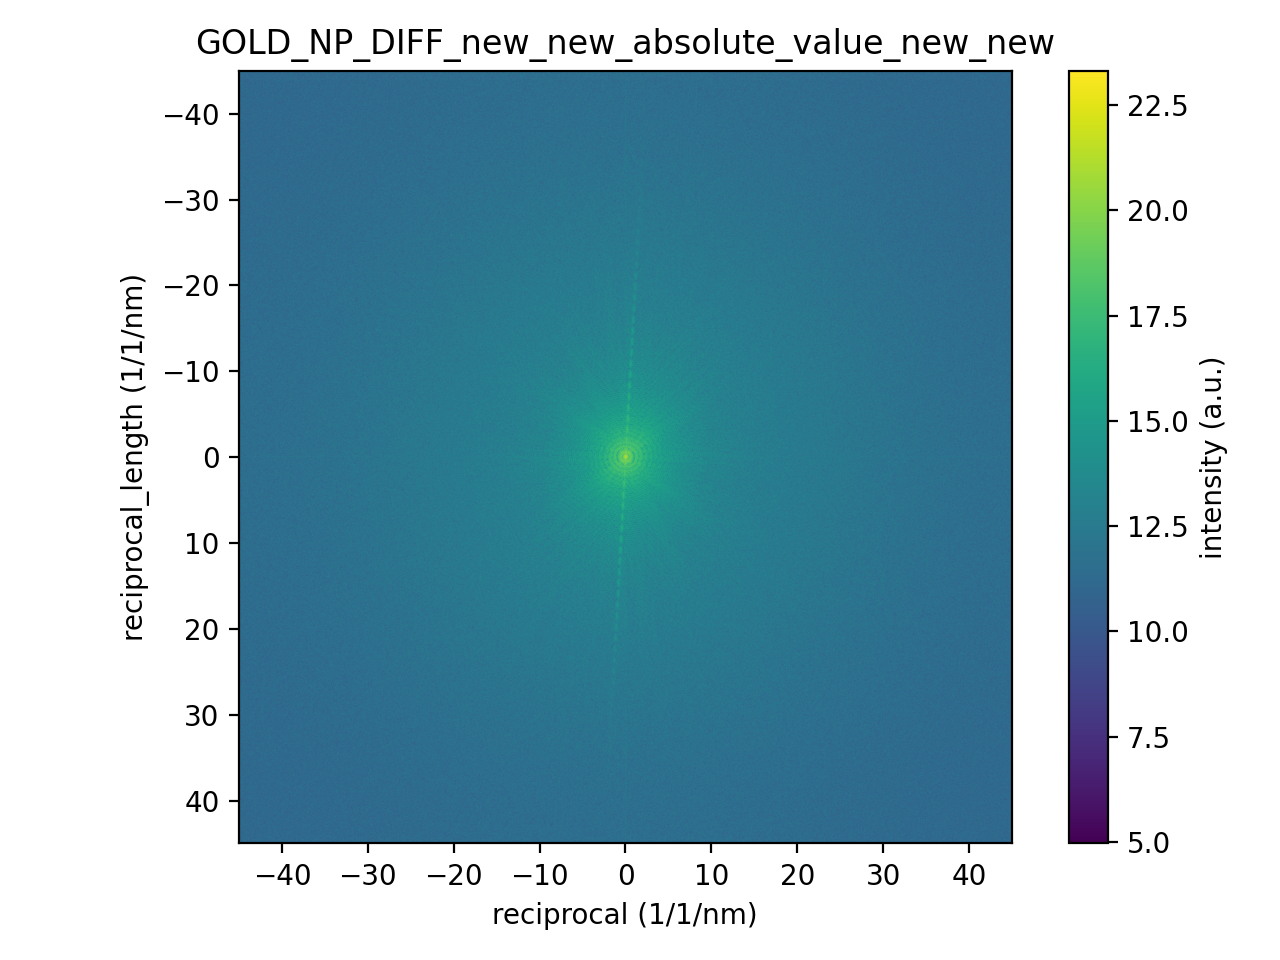

In [16]:
fft_image = current_dataset.fft().abs()
fft_image = np.log(60+fft_image)

view = fft_image.plot()

Now that we like this we log it.

Please note that just saving the fourier transform would not be good as we also need the scale and such.

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ GOLD_NP_DIFF
      ------------
      ├ GOLD_NP_DIFF
      ├ original_metadata
        -----------------
        ├ DM
          --
        ├ DocumentObjectList
          ------------------
          ├ 0
            -
            ├ AnnotationGroupList
              -------------------
              ├ 0
                -
                ├ Font
                  ----
                ├ ObjectTags
                  ----------
            ├ ImageDisplayInfo
              ----------------
              ├ DimensionLabels
                ---------------
              ├ MainSliceId
                -----------
            ├ ObjectTags
              ----------
        ├ DocumentTags
          ------------
        ├ Image Behavior
          --------------
          ├ UnscaledTransform
            -----------------
          ├ ZoomAndMoveTransform
            --------------------
        ├ ImageList
          ---------
     

C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:350: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<IPython.core.display.Javascript object>


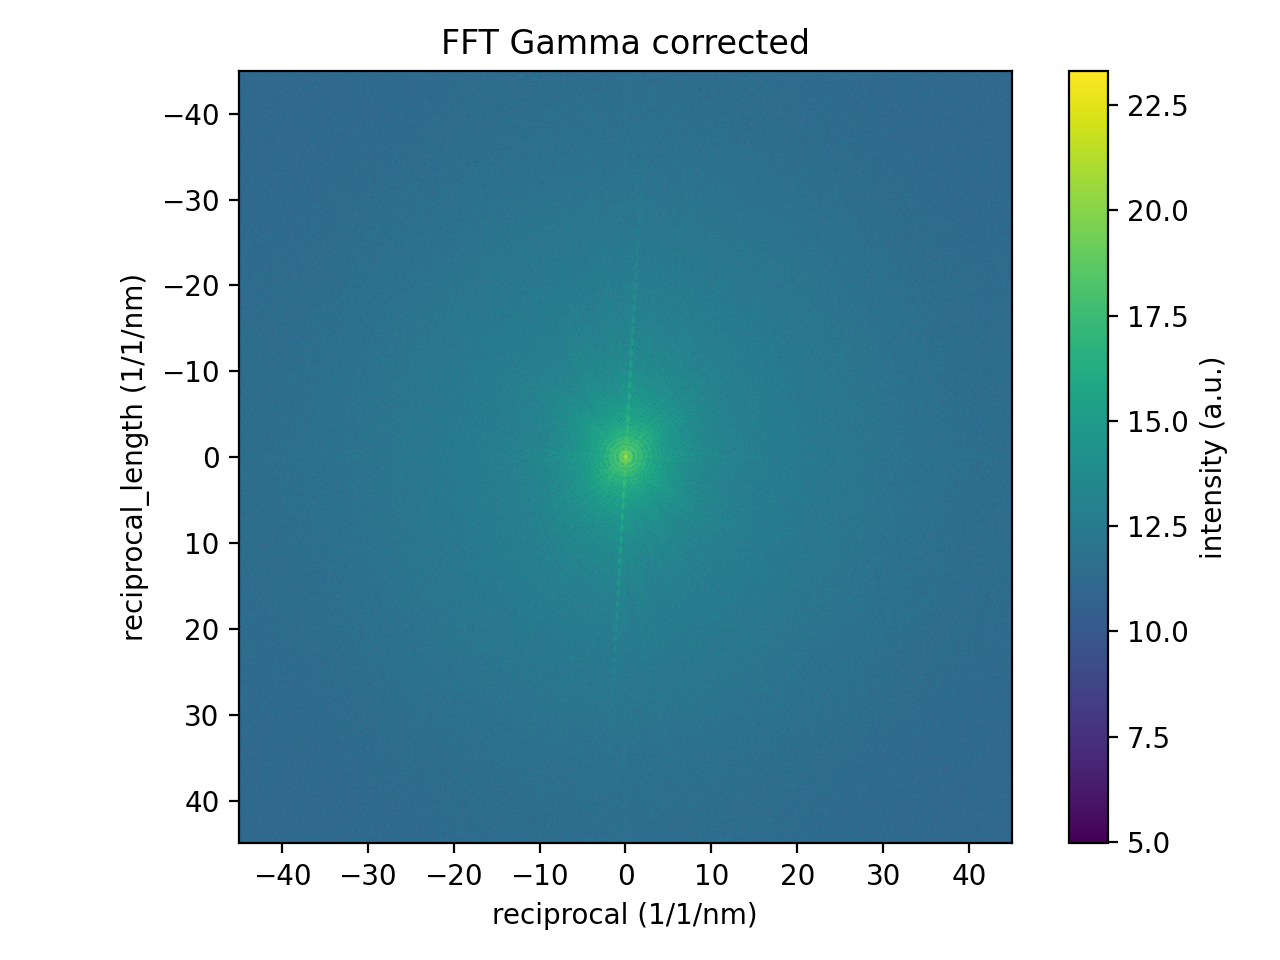

In [17]:
fft_image.title = 'FFT Gamma corrected'
fft_image.metadata = {'analysis': 'fft'}
log_group = ft.log_results(current_dataset, fft_image)

ft.h5_tree(current_channel.file)
view = fft_image.plot()

Please close the file

In [18]:
print(current_channel.file.filename)
h5_file.close()


C:\Users\gduscher\Documents\GitHub\MSE672-Introduction-to-TEM\example_data\GOLD_NP_DIFF-2.hf5


NameError: name 'h5_file' is not defined

## Open h5_file
Open the h5_file that we just created

In [19]:
dataset= ft.open_file()

current_channel = dataset.h5_dataset
view = dataset.plot()

file type not handled yet.


AttributeError: 'NoneType' object has no attribute 'h5_dataset'

### Short check if we got the data right
we print the tree and we plot the data

In [ ]:
# See if a tree has been created within the hdf5 file:
ft.h5_tree(dataset.h5_dataset.file)

## If we are done, we close the pyNSID style file.

This is necessary to make the file ready to be opened by another notebook or program.

In [ ]:
dataset.h5_dataset.file.close()


## Navigation
- <font size = "3">  **Back  [Matplotlib and Numpy for Micrographs](CH1_03-Data_Representation.ipynb)** </font>
- <font size = "3">  **Next: [Overview](CH1_06-Overview.ipynb)** </font>
- <font size = "3">  **Chapter 1: [Introduction](CH1_00-Introduction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>


In [ ]:
def onselect(verts):
    print('j')
    print(verts)
    self.canvas.draw_idle()

plt.figure()
plt.imshow(main_dataset)
poly = PolygonSelector(plt.gca(), onselect)

In [37]:
dir(poly)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_active',
 '_active_handle_idx',
 '_cids',
 '_clean_event',
 '_draw_polygon',
 '_get_data',
 '_on_key_press',
 '_on_key_release',
 '_on_scroll',
 '_onmove',
 '_polygon_completed',
 '_polygon_handles',
 '_press',
 '_prev_event',
 '_release',
 '_xs',
 '_ys',
 'active',
 'artists',
 'ax',
 'background',
 'canvas',
 'cids',
 'connect_default_events',
 'connect_event',
 'disconnect_events',
 'drawon',
 'eventpress',
 'eventrelease',
 'eventson',
 'get_active',
 'ignore',
 'line',
 'on_key_press',
 'on_key_release',
 'on_scroll',
 'onmove',
 'onselect',
 'press',
 'release',
 'set_active',
 'set_visible',
 'state',
 'state_mod

<IPython.core.display.Javascript object>


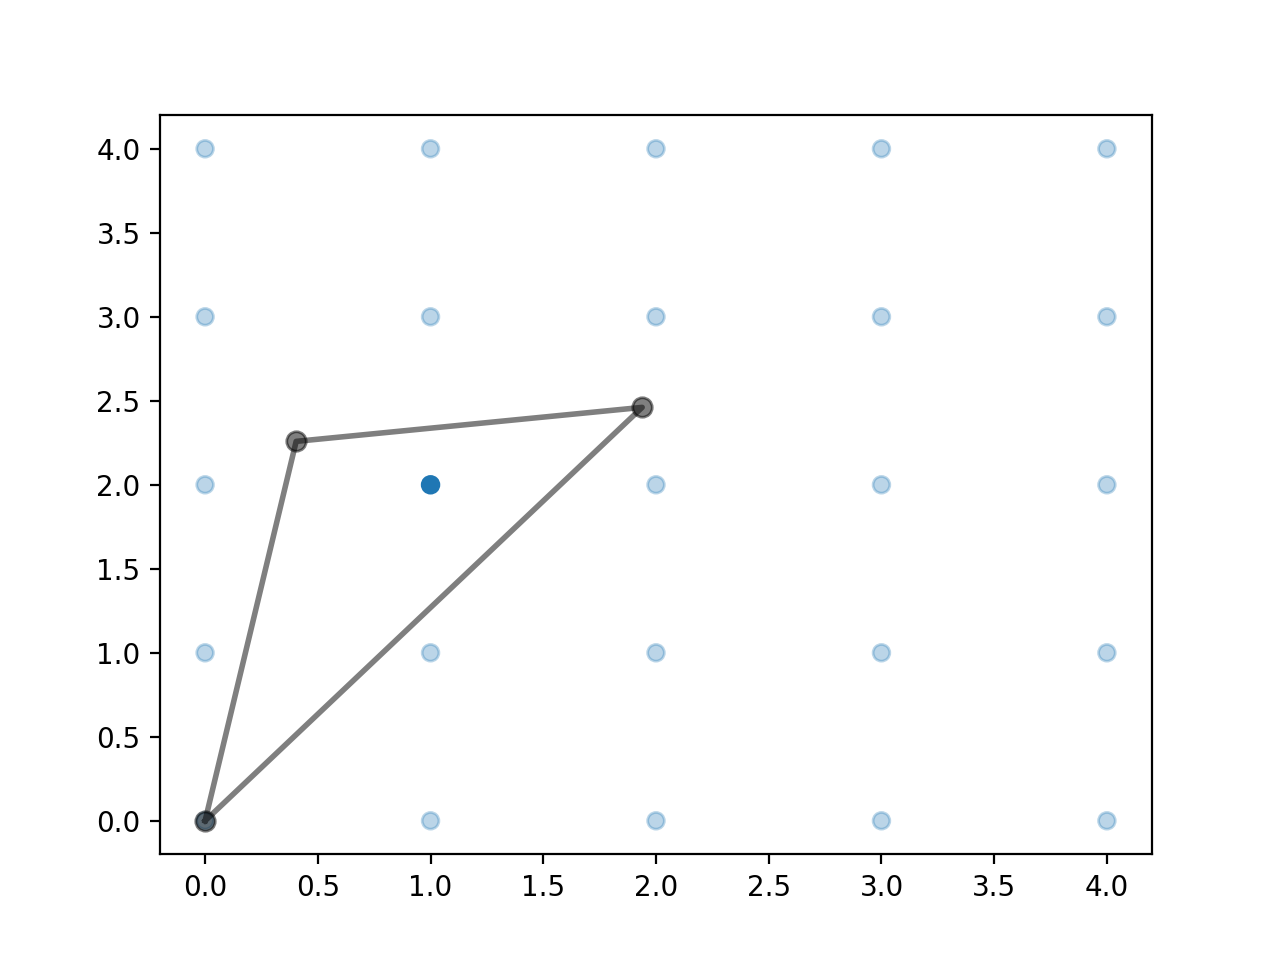

Select points in the figure by enclosing them within a polygon.
Press the 'esc' key to start a new polygon.
Try holding the 'shift' key to move all of the vertices.
Try holding the 'ctrl' key to move a single vertex.


In [22]:
from matplotlib.widgets import PolygonSelector
from matplotlib.path import Path


class SelectFromCollection:
    """
    Select indices from a matplotlib collection using `PolygonSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axes to interact with.
    collection : `matplotlib.collections.Collection` subclass
        Collection you want to select from.
    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to *alpha_other*.
    """

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.poly = PolygonSelector(ax, self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.poly.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()


import matplotlib.pyplot as plt

fig, ax = plt.subplots()
grid_size = 5
grid_x = np.tile(np.arange(grid_size), grid_size)
grid_y = np.repeat(np.arange(grid_size), grid_size)
pts = ax.scatter(grid_x, grid_y)

selector = SelectFromCollection(ax, pts)

print("Select points in the figure by enclosing them within a polygon.")
print("Press the 'esc' key to start a new polygon.")
print("Try holding the 'shift' key to move all of the vertices.")
print("Try holding the 'ctrl' key to move a single vertex.")

plt.show()

<IPython.core.display.Javascript object>


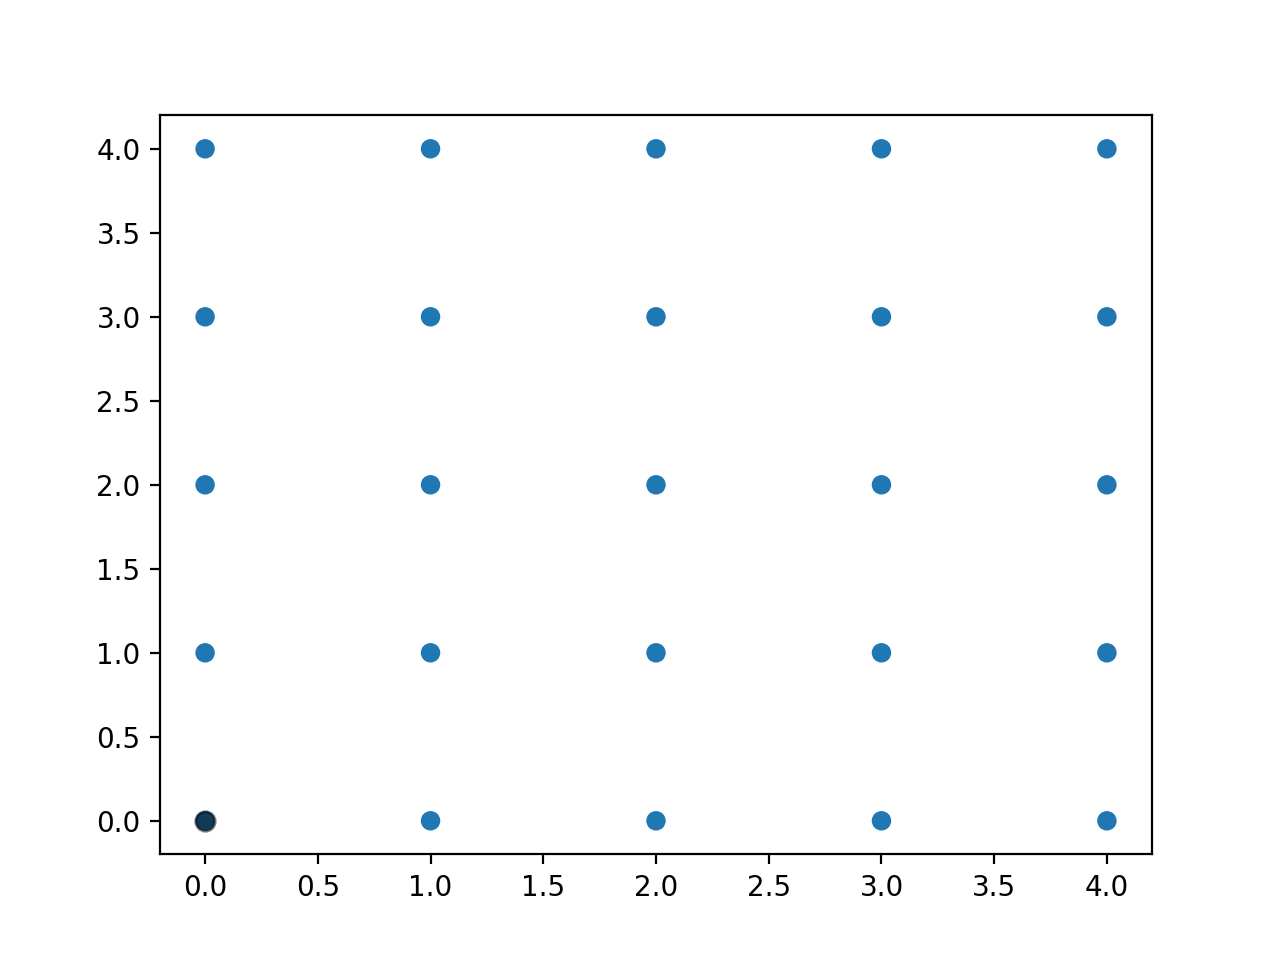

Select points in the figure by enclosing them within a polygon.
Press the 'esc' key to start a new polygon.
Try holding the 'shift' key to move all of the vertices.
Try holding the 'ctrl' key to move a single vertex.

Selected points:
[]


In [21]:
selector.disconnect()

# After figure is closed print the coordinates of the selected points
print('\nSelected points:')
print(selector.xys[selector.ind])